In [1]:
%load_ext autoreload
%autoreload 2
import param_tool as pt
import os 
import numpy as np
from rdkit.Chem.Draw import IPythonConsole
import sys
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdFMCS
from typing import Callable
import psiresp
import nglview as nv
import MDAnalysis as mda
import glob

import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display, clear_output

IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = (600, 400)

/home/n_kristovsky/.conda/envs/topmol2/lib/python3.8/site-packages/psiresp/charge.py:282: FutureWarning: `symmetric_atoms_are_equivalent` will be set to False by default for now, as it is a new feature. It will be set to True by default in the future
  warnings.warn(
/home/n_kristovsky/.conda/envs/topmol2/lib/python3.8/site-packages/psiresp/charge.py:282: FutureWarning: `symmetric_atoms_are_equivalent` will be set to False by default for now, as it is a new feature. It will be set to True by default in the future
  warnings.warn(


In [2]:
!pwd

/home/_shared/_projects/2022_md_FRET_nv/param_R_CIT


# Протокол расчета парциальных зарядов для модифицированных аминокислот
На вход подаються .smi-файлы мономера и полимеров аминокислоты, где аминокислота входит в состав полимера в положениях N M C. 
У мономера должны бать группы COO<sup>-</sup> и N<sup>+</sup>H<sub>3</sub>. У полимеров соответствующие группы на С и N концах.  

## Пример загрузки и отображения молекулы 

In [21]:
K_smi = pt.read_file('moleculse/Lysine_3M.smiles')
# R_CIT_smi = pt.read_file('moleculse/R_CIT.smiles')
K_chem = pt.smi_to_chem(K_smi, make_N_root=False)
# R_CIT_chem = pt.smi_to_chem(R_CIT_smi, make_N_root=True)

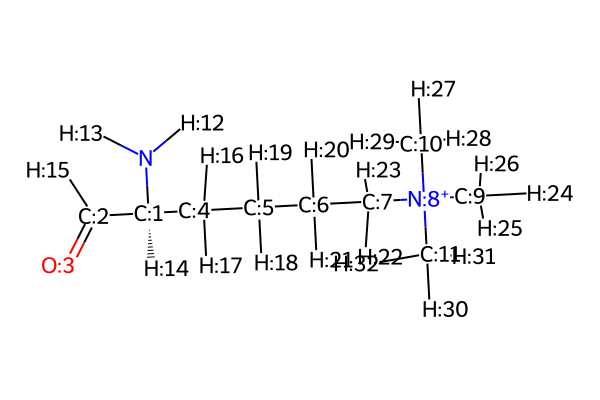

In [22]:
display(pt.draw_mol_with_atom_index(K_chem['Lysine_3M']))
# display(pt.draw_mol_with_atom_index(R_CIT_chem['R_CIT']))

## Шаг 1 Открытие .smi-файлов 
Мы рекомендуем использовать словари для записи фаилов молекул, также можно передать путь к  `.smi` в виде строки или листа. На выход вы получите словарь с соответствующими ключами. 

In [2]:
monomer_smi = pt.read_file('moleculse/Lysine_1M_ACC.smiles')
# monomer_smi =mon_name.read_file('moleculse/R_CIT.smiles')
trimers_smi = pt.read_file([
                            'moleculse/AKA_1M_ACC.smiles', 
                            # 'moleculse/GRG_CIT.smiles',
                            # 'moleculse/GR_CIT.smiles',

                           ],)
monomer_chem = pt.smi_to_chem(monomer_smi, make_N_root=False) # RDKit читает smi строку, переводит в chem и добавляет протоны
trimers_chem = pt.smi_to_chem(trimers_smi)
trimers_chem

{'AKA_1M_ACC': <rdkit.Chem.rdchem.Mol at 0x7f542e588280>}

In [13]:
# os.path.basename('moleculse/AKA_1M.smiles').split('.')[0]
mon_name = str(*monomer_smi.keys())
pol_name = str(*trimers_smi.keys())
print(mon_name, pol_name, sep='\n')

Lysine_1M_ACC
AKA_1M_ACC


## Шаг 2 Поиск подструктур мономера а.к. в полмерах
Наша задача выделить те атомы в составе полимеров, которые входят в состав мономера. Для этого функция `match_mon_to_pol` принимает на вход пару словарей с `Chem` фаилами. Словарь мономеров (один мономер) и полимеров (от 1 до ∞) соответственно. На выход подается словарь с ключами: `substructure`, `mon_pol_matches`, `N_match_atoms`, для кажого из полимеров. \
Где:
- `substructure` - сожердит общие подструктуры мономера и полимера, для каждого из полимеров в формате Chem .
- `mon_pol_matches` - содержит словари соответствия номеров атомов в общей подструктуре с номерами атомов в полимере молекула из общей подструктуры.
- `N_match_atoms` - количество общих атомов для мономера и полимера.\ 
(обычно вам не понадобится этот ключ, но он используется для подсвечивания общей структуры полимера на мономере)

Обратите внимание что набор атомов подструктур внутри мономера различается в зависимости от расположения а.к. в полимере

In [4]:
match_dict = pt.match_mon_to_pol(monomer_chem, trimers_chem, compare_any_bond = False)
# match_dict
print(match_dict.keys(),match_dict['substructure'], sep='\n')

dict_keys(['substructure', 'mon_pol_matches', 'N_match_atoms'])
{'AKA_1M_ACC': <rdkit.Chem.rdchem.Mol object at 0x7f542e5885e0>}


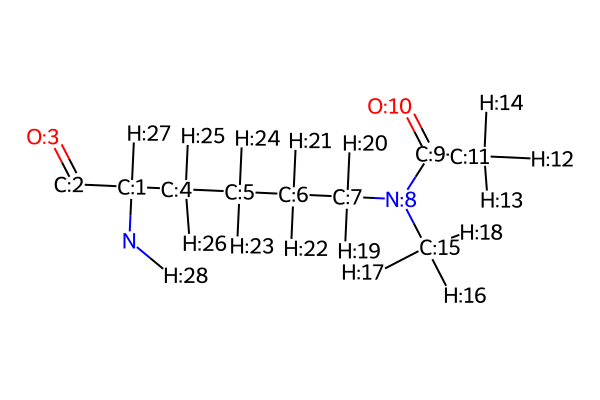

In [8]:
pt.draw_mol_with_atom_index(match_dict['substructure'][pol_name])

### Отрисовка полученных подструктур на молекулах мономера и полимера
Позволяет убедится в корректности структур

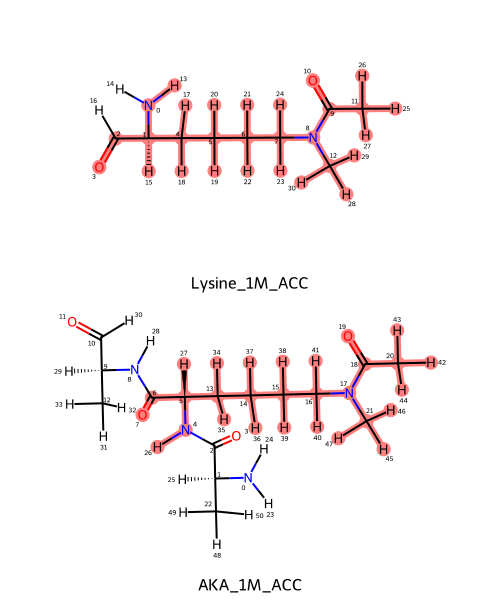

In [10]:
pt.draw_mon_pol_match(monomer_chem, trimers_chem, match_dict, add_small_atom_index=True)

## Шаг 3 Сохранение молекул подструктур для N M С позиций 

Из молекулы мономера были выделены структуры аминокислот для каждой из позиций `N` `M` `C`. Важно ответить, что при созранение подструктур идет переупордочивание атомов таким образом, что первым атомом в молекуле становится автом **N** в составе аминогруппы. Далее имено они будут использоваться при получении файлов топологии. \
Ниже представленно несколько вариантов сохранения подструктур, но в итоге будут использоватсья файлы формата `.pdb` 

Были получены молекулярные формулы параметризируемых остатков `match_dict['substructure']`. Именно они будут использоваться для получения фаилов топологии в следующем ноутбуке.

#### Сохранение подструктур в виде **smiles**

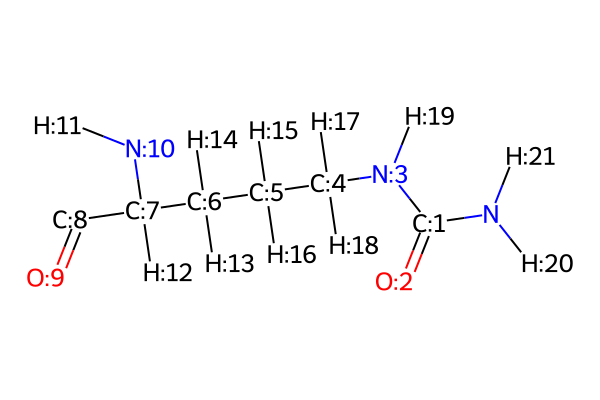

In [22]:
pt.draw_mol_with_atom_index(match_dict['substructure']['GRG_CIT'])

In [25]:
sub_name = ['R_CIT_inter', ]
for chem_name, chem_mol in zip(sub_name, match_dict['substructure'].values()):
    pt.save_aa_chem_to_smiles(chem_mol, f'moleculse/substructure/{chem_name}', canonical=False ,make_N_root=False)

R_CIT_inter.smiles saved to moleculse/substructure


/home/n_kristovsky/.conda/envs/topmol2/lib/python3.8/site-packages/psiresp/charge.py:282: FutureWarning: `symmetric_atoms_are_equivalent` will be set to False by default for now, as it is a new feature. It will be set to True by default in the future
  warnings.warn(


In [23]:
sub_name = ['NR_CIT_1', 'R_CIT_1', 'CR_CIT_1']
for chem_name, chem_mol in zip(sub_name, match_dict['substructure'].values()):
    pt.save_aa_chem_to_smiles(chem_mol, f'moleculse/substructure/{chem_name}',make_N_root=True)

atom number: 10 became the root atom: 0
NR_CIT_1.smiles saved to moleculse/substructure
atom number: 10 became the root atom: 0
R_CIT_1.smiles saved to moleculse/substructure
atom number: 11 became the root atom: 0
CR_CIT_1.smiles saved to moleculse/substructure


##### Проверка сохраненных подструктур

In [26]:
test_smi = pt.read_file(['moleculse/substructure/R_CIT_inter.smiles',
              # 'moleculse/substructure/R_CIT_1.smiles',
              # 'moleculse/substructure/CR_CIT_1.smiles'
                        ])
test_chem = pt.smi_to_chem(test_smi, addH=False, sanitize=False)
IPythonConsole.drawOptions.addAtomIndices = False

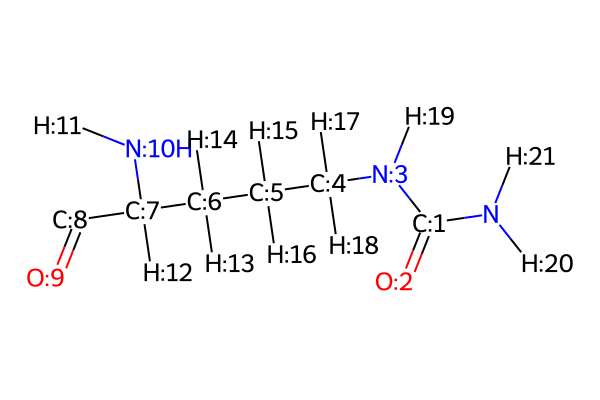

In [27]:
pt.draw_mol_with_atom_index(test_chem['R_CIT_inter'])
# pt.draw_mol_with_atom_index(test_chem['R_CIT'])
# pt.draw_mol_with_atom_index(test_chem['CR_CIT_1'])

In [24]:
test_smi = pt.read_file(['moleculse/substructure/NR_CIT_1.smiles',
              'moleculse/substructure/R_CIT_1.smiles',
              'moleculse/substructure/CR_CIT_1.smiles'])
test_chem = pt.smi_to_chem(test_smi, addH=False, sanitize=False)
IPythonConsole.drawOptions.addAtomIndices = False

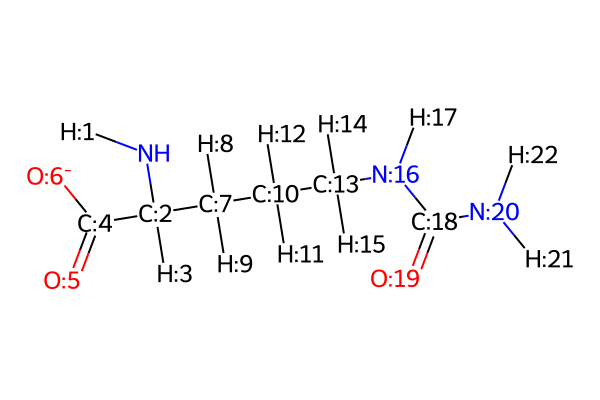

In [25]:
pt.draw_mol_with_atom_index(test_chem['NR_CIT_1'])
# pt.draw_mol_with_atom_index(test_chem['R_CIT'])
pt.draw_mol_with_atom_index(test_chem['CR_CIT_1'])

### Сохранение подструктур в виде mol

In [30]:
list_N = []
for sub in match_dict['substructure'].values():
    N_index = pt.find_amino_nitrogen(sub)
    list_N.append(N_index)
print(list_N)
sub_name = ['NR_CIT', 'R_CIT', 'CR_CIT']
for chem_name, chem_mol, root in zip(sub_name, match_dict['substructure'].values(), list_N):
    pt.save_chem_to_mol(chem_mol, f'moleculse/substructure/{chem_name}', rootedAtAtom = root)
    print(chem_name, chem_mol)

10
10
11
[10, 10, 11]
NR_CIT <rdkit.Chem.rdchem.Mol object at 0x7f944627bee0>
R_CIT <rdkit.Chem.rdchem.Mol object at 0x7f944627bf40>
CR_CIT <rdkit.Chem.rdchem.Mol object at 0x7f9480340400>


In [53]:
mol_test = Chem.MolFromMolFile('moleculse/substructure/NR_CIT.mol', sanitize=False,removeHs=False)
# Chem.AddHs(mol_test)

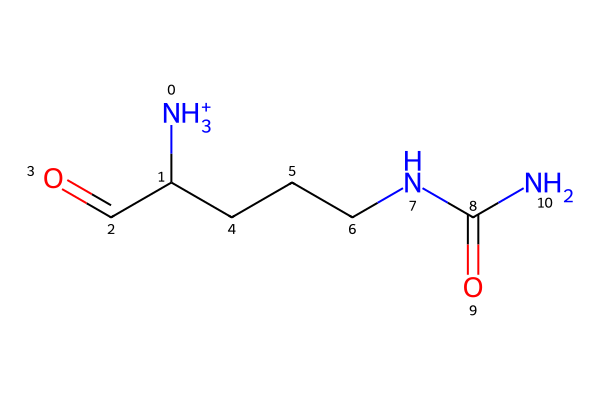

In [54]:
mol_test

In [41]:
IPythonConsole.drawOptions.addAtomIndices = True
mol_test

In [21]:
!pwd

/home/_shared/_projects/2022_md_FRET_nv/param_R_CIT


### Сохранение подструктур в виде **pdb**

То как выглядит подструктура для одного из вариантов позиционирования остатка в цепи:

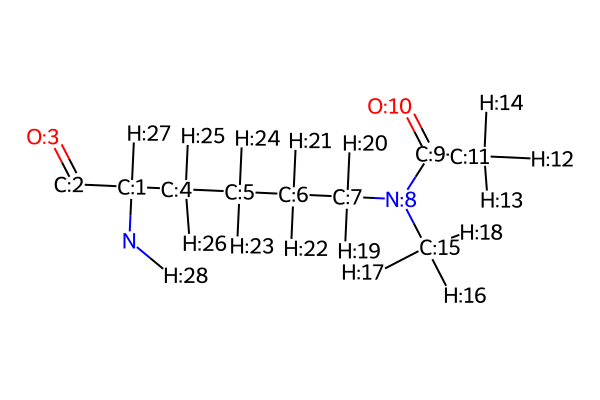

In [11]:
pt.draw_mol_with_atom_index(match_dict['substructure'][pol_name])

Сохранение подструктуры (т.е. атомов входящих в состав модифицированного остатка в зависимости от его позиции в полимере) в формате 
`pdb`. \
Далее полученные ДНК используются для получения парциальных зарядов и для получения файлов топологии. \
Кроме этого вы можете взять их и использовать в молекулярном  моделировании для добавления модифицированного остатка в вашу структуру.   

##### Одиночное сохранение:
Мы сохраняем остаток ак в составе которго атомы только входящие в этот остаток. \
Все имен аатомов уникальные

In [14]:
pt.save_aa_chem_to_pdb(match_dict['substructure'][pol_name], 
                       f'moleculse/substructure/{mon_name}', 
                       resname = 'KMA', 
                       resid= 1,
                       segid= 'A',
                       make_N_root=False)

Длина atom_names_list не совпадает с количеством атомов в rdkit_mol. Будут использованы стандартные имена атомов.
Lysine_1M_ACC.pdb saved to moleculse/substructure


[10:15:22] Molecule does not have explicit Hs. Consider calling AddHs()
[10:15:22] Molecule does not have explicit Hs. Consider calling AddHs()


##### Множественное сохранение:

In [10]:
sub_name = ['NR_CIT_1', 'R_CIT_1', 'CR_CIT_1']
resname_l = ['NRC', 'RC', 'CRC']
for chem_name, chem_mol, resname in zip(sub_name, match_dict['substructure'].values(), resname_l):
    pt.save_aa_chem_to_pdb(chem_mol, f'moleculse/substructure/{chem_name}_rdkit', resname = resname, make_N_root=True)

atom number: 0 became the root atom: 0
Длина atom_names_list не совпадает с количеством атомов в rdkit_mol. Будут использованы стандартные имена атомов.
NR_CIT_1_rdkit.pdb saved to moleculse/substructure


[13:16:38] Molecule does not have explicit Hs. Consider calling AddHs()
[13:16:38] Molecule does not have explicit Hs. Consider calling AddHs()


#### Проверка сохраненных молекул

In [15]:
test_pdb = pt.pdb_to_chem('moleculse/substructure/Lysine_1M_ACC.pdb',
              # 'moleculse/substructure/R_CIT.pdb',
              # 'moleculse/substructure/CR_CIT.pdb'
              
                       )

# IPythonConsole.drawOptions.addAtomIndices = False
test_pdb

{'Lysine_1M_ACC': <rdkit.Chem.rdchem.Mol at 0x7f542dcf40a0>}

Если все получилось, то вы молжны получить картинку тогоже остатка с такимиже типами связей и количеством атомов. \
В случае если вы использовали `make_N_root=True` последовательность нумерации атомов должна была поменяться и нулевым атомом должен был стать `N` в аминогруппе

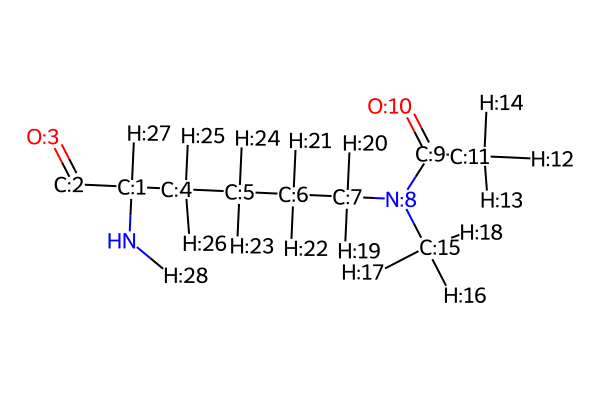

In [16]:
pt.draw_mol_with_atom_index(test_pdb['Lysine_1M_ACC'])

##### NGLview отрисовка

Поскольку мы сохранили pdb фаил то можно и через MDAnalysis и nglview посмотреть на него

In [36]:
nv.show_mdanalysis(mda.Universe('moleculse/substructure/NR_CIT_1_rdkit.pdb'))

NGLWidget()

### Шаг 3.1. Переименовка атомов в составе остатка с присвоением канонических имен к каноничным атомам  

In [57]:
# def rename_aa_atoms_by_canon(path_to_mod_aa_dict):

# RDKit.Chem для сопоставления модифицированного остатка с стандартным остатком

path_to_mod_aa_dict = 'moleculse/substructure/Lysine_1M_ACC.pdb'
mod_aa_name = os.path.basename(path_to_mod_aa_dict).split('.')[0]
print(mod_aa_name)

mod_aa_chem_dict = pt.pdb_to_chem(path_to_mod_aa_dict)
# ref_aa_chem_dict = pt.pdb_to_chem(glob.glob('moleculse/aminoacids_template/*'))
ref_aa_chem_dict = pt.pdb_to_chem(glob.glob('moleculse/aminoacids_template/K.pdb'))
match_data_dict = pt.match_mon_to_pol(mod_aa_chem_dict, ref_aa_chem_dict)
# match_data_dict['mon_pol_matches']['KKK']

Lysine_1M_ACC


In [51]:
# Можно сделать чтобы для максимального сопоставлени ястроился матч тогда будут созранены хайлайты на структурах от него 
# Либо строить сопоставление всех матчей, но это много... 20 АК...  

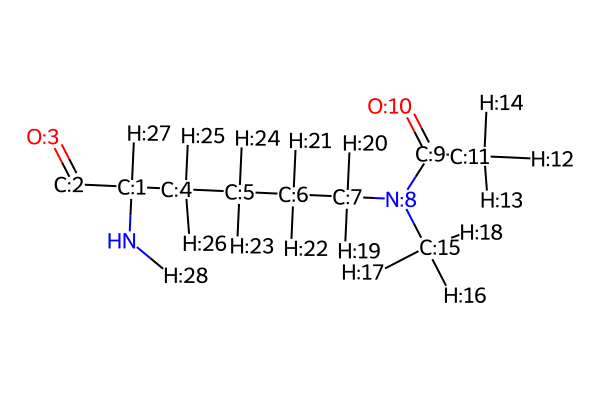

In [58]:
pt.draw_mol_with_atom_index(mod_aa_chem_dict[mod_aa_name])

 Lysine_1M_ACC has max matches atoms (19) with K amino acids 


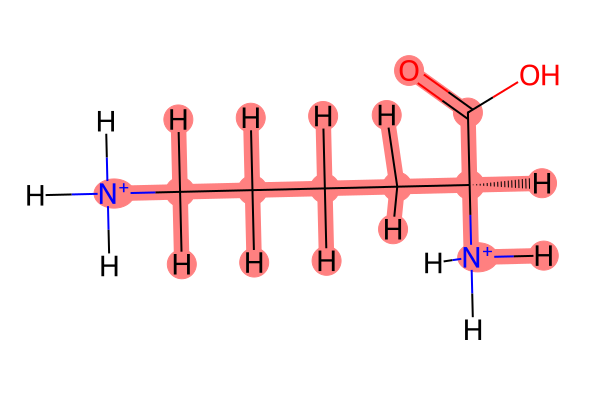

In [59]:
# Выявление остатка с которым наибольшая общая подструктура 
name, chem = next(iter(mod_aa_chem_dict.items()))
max_key = max(match_data_dict['N_match_atoms'])
ref_aa_name = match_data_dict['N_match_atoms'][max_key]
print(f" {name} has max matches atoms ({max_key}) with {ref_aa_name} amino acids ")
ref_aa_chem_dict[ref_aa_name]

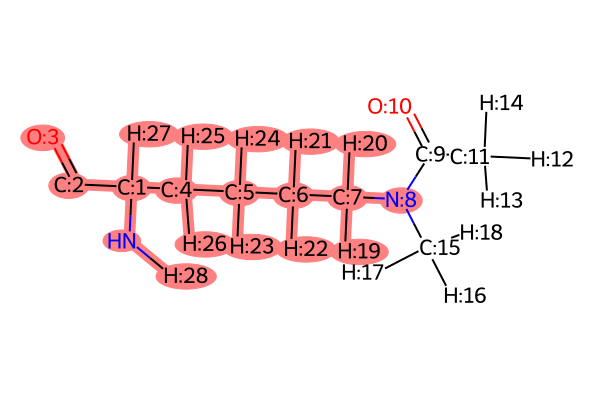

In [60]:
mod_aa_chem_dict['Lysine_1M_ACC']

In [95]:
# MDAnalysis для корректного присаивания имен атомов из референсного остатка модифицированному
import re
from collections import Counter

# MDAnalysis для корректного присваивания имен атомов из референсного остатка модифицированному
mod_universe_mda = mda.Universe('moleculse/substructure/Lysin_2M.pdb')
ref_universe_mda = mda.Universe(f'moleculse/aminoacids_template/{ref_aa_name}.pdb')

dict_mol1_mol2_matches = match_data_dict['mon_pol_matches'][ref_aa_name]

for mod_indx, ref_indx in dict_mol1_mol2_matches.items():
    all_mod_atom_names = mod_universe_mda.atoms.names
    mod_atom_name = mod_universe_mda.atoms[mod_indx].name
    ref_atom_name = ref_universe_mda.atoms[ref_indx].name
    
    
    # Проверяем, нужно ли изменять имя
    
    if ref_atom_name in all_mod_atom_names:
        new_name = ref_atom_name
        counter = 1
        while new_name in all_mod_atom_names:
            # Изменяем только числовую часть имени
            match = re.match(r"(\D+)(\d*)", ref_atom_name)
            if match:
                prefix = match.group(1)  # Буквенная часть
                suffix = match.group(2)  # Числовая часть (может быть пустой)
                new_name = f"{prefix}{int(suffix) + counter if suffix else counter}"
                print(f'The name {ref_atom_name} -> {new_name}')
            else:
                # Если имя не содержит числовой части, добавляем ее
                new_name = f"{ref_atom_name}{counter}"
                print(f'The name {ref_atom_name} -> {new_name}')
            counter += 1
        atom_indx = list(mod_universe_mda.atoms.names).index(ref_atom_name)
        mod_universe_mda.atoms[atom_indx].name = new_name

    print(f'({mod_indx}:{mod_atom_name}) -> ({ref_indx}:{ref_atom_name})')
    mod_universe_mda.atoms[mod_indx].name = new_name  # Устанавливаем уникальное имя

mod_universe_mda.atoms.write('moleculse/substructure/Lysin_2M_RENAME.pdb')

# Проверяем, что все имена уникальны
all_mod_atom_names = mod_universe_mda.atoms.names
name_counts = Counter(all_mod_atom_names)  # Подсчитываем частоту каждого имени
duplicates = [name for name, count in name_counts.items() if count > 1]  # Список дубликатов

if duplicates:
    print("В модифицированной молекуле обнаружены повторяющиеся имена атомов:")
    for name in duplicates:
        print(f"Имя: {name}, количество повторений: {name_counts[name]}")
    raise ValueError("Обнаружены повторяющиеся имена атомов. Проверьте логи для деталей.")
else:
    print("Все имена атомов уникальны.")



(0:N1) -> (0:N)
(1:C1) -> (1:CA)
(2:C2) -> (2:C)
(3:O1) -> (3:O)
(4:C3) -> (4:CB)
(5:C4) -> (5:CG)
(6:C5) -> (6:CD)
(7:C6) -> (7:CE)
(8:N2) -> (8:NZ)
(13:C8) -> (21:HZ1)
(14:H4) -> (22:HZ2)
(15:H5) -> (16:HE2)
(16:H6) -> (17:HE3)
(17:H7) -> (14:HD2)
(18:H8) -> (15:HD3)
(19:H9) -> (12:HG2)
(20:H10) -> (13:HG3)
(21:H11) -> (10:HB2)
(22:H12) -> (11:HB3)
(23:H13) -> (9:HA)
The name H1 -> H2
The name H1 -> H3
The name H1 -> H4
The name H1 -> H5
(24:H14) -> (18:H1)
В модифицированной молекуле обнаружены повторяющиеся имена атомов:
Имя: H4, количество повторений: 20
Имя: H5, количество повторений: 2


/home/n_kristovsky/.conda/envs/topmol2/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:753: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "


ValueError: Обнаружены повторяющиеся имена атомов. Проверьте логи для деталей.

In [62]:
import re
import MDAnalysis as mda

# Инициализация объектов MDAnalysis
mod_universe_mda = mda.Universe(path_to_mod_aa_dict)
ref_universe_mda = mda.Universe(f'moleculse/aminoacids_template/{ref_aa_name}.pdb')

dict_mol1_mol2_matches = match_data_dict['mon_pol_matches'][ref_aa_name]

# Обновляем имена атомов, чтобы избежать конфликтов
for mod_indx, ref_indx in dict_mol1_mol2_matches.items():
    mod_atom = mod_universe_mda.atoms[mod_indx]
    ref_atom = ref_universe_mda.atoms[ref_indx]

    mod_atom_name = mod_atom.name
    ref_atom_name = ref_atom.name

    # Если имя уже существует в модифицированной структуре
    all_mod_atom_names = set(mod_universe_mda.atoms.names)
    if ref_atom_name in all_mod_atom_names:
        new_name = ref_atom_name
        counter = 1

        while new_name in all_mod_atom_names:
            # Добавляем числовой суффикс к имени, чтобы оно стало уникальным
            match = re.match(r"(\D+)(\d*)", ref_atom_name)
            if match:
                prefix = match.group(1)  # Буквенная часть имени
                suffix = match.group(2)  # Числовая часть (если есть)
                new_name = f"{prefix}{int(suffix) + counter if suffix else counter}"
            else:
                new_name = f"{ref_atom_name}{counter}"

            counter += 1

        print(f"Changing name: {ref_atom_name} -> {new_name}")
        mod_atom.name = new_name  # Устанавливаем новое имя
        all_mod_atom_names.add(new_name)  # Добавляем в список существующих имен

    else:
        mod_atom.name = ref_atom_name  # Присваиваем оригинальное имя, если оно уникально

# Сохраняем измененную структуру
output_path = f'moleculse/substructure/{mod_aa_name}.pdb'
mod_universe_mda.atoms.write(output_path)
print(f"Updated PDB file saved to {output_path}")


Changing name: H1 -> H7
Updated PDB file saved to moleculse/substructure/Lysine_1M_ACC.pdb


In [96]:
chek_mol = mda.Universe('moleculse/substructure/Lysin_2M_RENAME.pdb')

all_mod_atom_names = chek_mol.atoms.names
name_counts = Counter(all_mod_atom_names)  # Подсчитываем частоту каждого имени
duplicates = [name for name, count in name_counts.items() if count > 1]  # Список дубликатов

if duplicates:
    print("В модифицированной молекуле обнаружены повторяющиеся имена атомов:")
    for name in duplicates:
        print(f"Имя: {name}, количество повторений: {name_counts[name]}")
    raise ValueError("Обнаружены повторяющиеся имена атомов. Проверьте логи для деталей.")
else:
    print("Все имена атомов уникальны.")

В модифицированной молекуле обнаружены повторяющиеся имена атомов:
Имя: H4, количество повторений: 20
Имя: H5, количество повторений: 2


/home/n_kristovsky/.conda/envs/topmol2/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:432: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


ValueError: Обнаружены повторяющиеся имена атомов. Проверьте логи для деталей.

In [97]:
nv.show_mdanalysis(mda.Universe('moleculse/substructure/Lysin_1M_RENAME.pdb'))

NGLWidget()

In [99]:
pt.draw_mol_with_atom_index(mod_aa_chem_dict['Lysin_3M'])

KeyError: 'Lysin_3M'

In [48]:
mod_aa_chem_dict['Lysin_3M'].GetNumAtoms()

33

In [207]:
test_pdb_dict = pt.pdb_to_chem('moleculse/substructure/TestNR_CIT_mod.pdb')
ref_aa = pt.pdb_to_chem('moleculse/aminoacids_template/RRR.pdb')
print(test_pdb_dict, ref_aa)

{'RRR': <rdkit.Chem.rdchem.Mol at 0x7fbfb9a03640>}

In [196]:
substructure, dict_mol1_mol2_matches = pt.match_chem(ref_aa['RRR'], test_pdb_dict['TestNR_CIT_mod'])

In [205]:
substructure.GetNumAtoms()

23

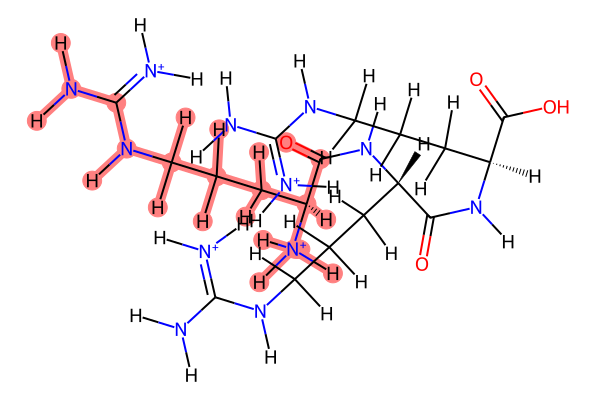

In [197]:
ref_aa['RRR']

In [25]:
# NR = mda.Universe('moleculse/aminoacids_template/NR.pdb')
NRCIT = mda.Universe('moleculse/substructure/TestNR_CIT_mod.pdb')
NRCIT.residues.resnums

/home/n_kristovsky/.conda/envs/topmol2/lib/python3.8/site-packages/psiresp/charge.py:282: FutureWarning: `symmetric_atoms_are_equivalent` will be set to False by default for now, as it is a new feature. It will be set to True by default in the future
  warnings.warn(


array([2])

In [184]:
for ref_indx, mod_indx in dict_mol1_mol2_matches.items():
    print( NR.atoms.names[ref_indx] + ':' + NRCIT.atoms.names[mod_indx])

N:N1
CA:C1
CB:C2
CG:C3
CD:C4
NE:N2
CZ:C5
NH1:N3
HH11:H1
HH12:H2
HE:H3
HD2:H4
HD3:H5
HG2:H6
HG3:H7
HB2:H8
HB3:H9
C:C6
O:O2
HA:H10
H1:H11
H2:H12
H3:H13


/home/n_kristovsky/.conda/envs/topmol2/lib//python3.8/site-packages/MDAnalysis/coordinates/PDB.py:432: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


In [193]:
for ref_indx, mod_indx in dict_mol1_mol2_matches.items():
    NRCIT.atoms[mod_indx].name = NR.atoms[ref_indx].name 
print(NRCIT.atoms.names)

['N' 'CA' 'CB' 'CG' 'CD' 'NE' 'CZ' 'NH1' 'HH11' 'HH12' 'O1' 'HE' 'HD2'
 'HD3' 'HG2' 'HG3' 'HB2' 'HB3' 'C' 'O' 'HA' 'H1' 'H2' 'H3']


In [190]:
# NRCIT.atoms.names[1] = 'AD'
NRCIT.atoms.

'C1'

In [191]:
print(dict_mon_pol_matches)

{0: 0, 1: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: 7, 19: 8, 20: 9, 18: 11, 16: 12, 17: 13, 14: 14, 15: 15, 12: 16, 13: 17, 2: 18, 3: 19, 11: 20, 23: 21, 24: 22, 25: 23}


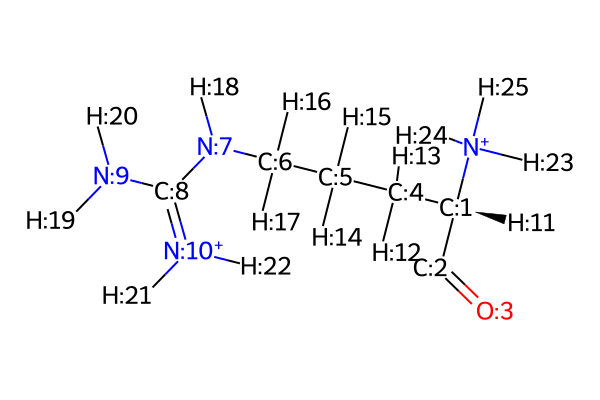

In [177]:
pt.draw_mol_with_atom_index(ref_aa['NR'])

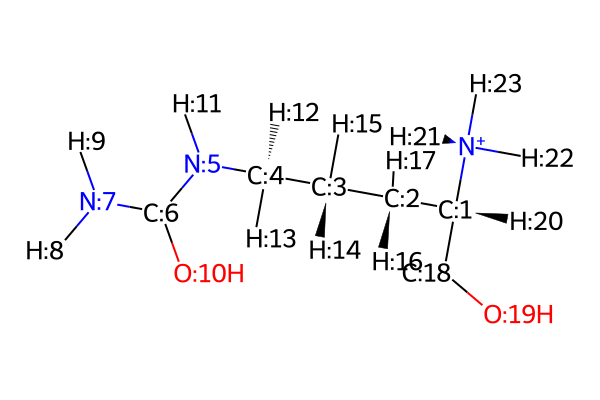

In [169]:
pt.draw_mol_with_atom_index(test_pdb_dict['TestNR_CIT_mod'])

In [151]:
mda_sub.residues.resids

array([1])

In [ ]:
list_N = []
for sub in match_dict['substructure'].values():
    N_index = pt.find_amino_nitrogen(sub)
    list_N.append(N_index)
print(list_N)
sub_name = ['NR_CIT', 'R_CIT', 'CR_CIT']
for chem_name, chem_mol, root in zip(sub_name, match_dict['substructure'].values(), list_N):
    pt.save_chem_to_pdb(chem_mol, f'moleculse/substructure/{chem_name}', rootedAtAtom = root)
    print(chem_name, chem_mol)

### Проверка созданных молекул
1. Порядок нумерации атомов

#### SMI

#### PDB

## Расчет зарядов при помощи библиотеки psiresp

На вход: 
- Молекула-ы в виде тримеров в формате smiles. 

Задача ограничейни зарядов для одной молекулы
Словарь собранный для каждой молекулы полимера. Для каждого полимера он свой.
Задача ограничений зарядов для набора молекул
При растчете зарядов для нескольких молекул одновременно constraints теряются и не учитываются при расчетах. 
Так же теряется симетрия атомов. В связи с этим при использовании psiresp будут проводится расчеты для одной молекулы за раз. 



Создание ограничений

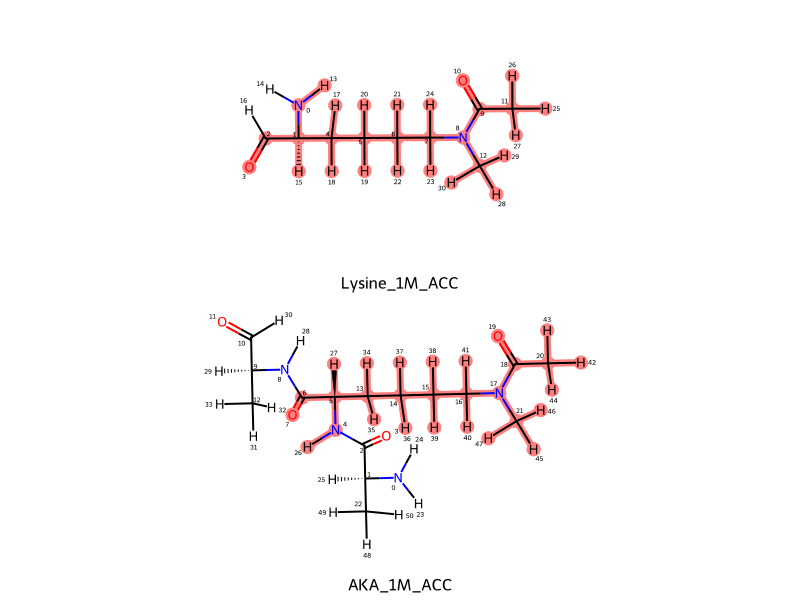

In [63]:
# monomer_chem = pt.pdb_to_chem([
              # 'moleculse/substructure/NR_CIT.pdb',
              # 'moleculse/mod_aa/Lysine_3M.pdb',
              # 'moleculse/substructure/CR_CIT.pdb',
                        # ])
trimers_smi = pt.read_file([
                            'moleculse/AKA_1M_ACC.smiles'
                            # 'moleculse/RA_CIT.smiles', 
                            # 'moleculse/GRG_CIT.smiles',
                            # 'moleculse/GR_CIT.smiles',
                            # 'moleculse/RGG_CIT.smiles',
                            # 'moleculse/sRs_CIT.smiles'
                            # 'moleculse/GRG_CIT.smiles',
                            # 'moleculse/ARV_CIT.smiles'
                            # 'moleculse/GGR_CIT.smiles'
                           ])
monomer_chem = pt.smi_to_chem(pt.read_file('moleculse/Lysine_1M_ACC.smiles'),sanitize = True, make_N_root=False) # RDKit читает smi строку, переводит в chem и добавляет протоны
trimers_chem = pt.smi_to_chem(trimers_smi)
trimers_chem

match_dict = pt.match_mon_to_pol(monomer_chem, trimers_chem, compare_any_bond = False)
pt.draw_mon_pol_match(monomer_chem, trimers_chem, match_dict, add_small_atom_index=True, img_size=(800,300))

In [65]:
# pt.save_aa_chem_to_smiles(trimers_chem['AKA_1M_ACC'], 'moleculse/AKA_H_out.smi',allHsExplicit=True)

In [68]:
# pt.draw_mol_with_atom_index(trimers_chem['AKA_1M_ACC'], size=(1200,600))

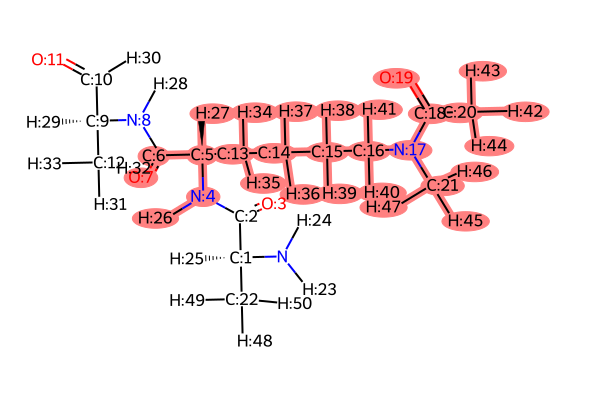

In [70]:
trimers_chem['AKA_1M_ACC']

In [74]:
constraint_dict = {'NR_CIT':
                  {'symmetric_list': [],
                   'charge_atom_dict': {16: 0.1305, 32:0.2083, 33:0.2083, 34:0.2083, 7:-0.0223, 26:0.1242, 8:0.7214, 9:-0.6013},
                   'charge_of_monomer': 0.0000,
                  },
                   'AKA':
                  {'symmetric_list': [[33,34], [35,36], [37,38], [39,40], [18,19,20], [41, 42, 43, 44,45,46, 47,48,49]],
                   'charge_atom_dict': {4:-0.34790, 25:0.27470, 5:-0.24000, 6:0.73410, 7:-0.58940, 26:0.14260},
                   'charge_of_monomer': 1.0000,
                  },
                   'AKA_2M':
                  {'symmetric_list': [[33,32], [35,34], [37,36], [39,38], [41, 42, 43], [44,45,46]],
                   'charge_atom_dict': {4:-0.34790, 24:0.27470, 5:-0.24000, 6:0.73410, 7:-0.58940, 25:0.14260},
                   'charge_of_monomer': 1.0000,
                  },
                   'AKA_1M':
                  {'symmetric_list': [[31,32], [33,34], [35,36], [37,38], [39, 40], [41,42,43]],
                   'charge_atom_dict': {4:-0.34790, 23:0.27470, 5:-0.24000, 6:0.73410, 7:-0.58940, 24:0.14260, 31: 0.03620, 32: 0.03620},
                   'charge_of_monomer': 1.0000,
                  },
                   'AKA_1M_ACC':
                  {'symmetric_list': [[34,35], [36,37], [38,39], [40,41], [42, 43, 44], [45, 46, 47]],
                   'charge_atom_dict': {4:-0.34790, 26:0.27470, 5:-0.24000, 6:0.73410, 7:-0.58940, 27:0.14260},
                   'charge_of_monomer': 0.0000,
                  }
                   
                  }

In [75]:
# psiresp_dict, constraints = pt.prepere_constraints('RA_CIT', trimers_chem , match_dict, 
#                                                    constraint_dict, 
#                                                    conformer_generation_options = dict(n_conformer_pool=1000,
#                                                             n_max_conformers=1, energy_window = 100, 
#                                                             keep_original_conformer=False))

In [86]:
param_mol_name = 'AKA_1M_ACC'
psiresp_dict = {}
RESP_mol= psiresp.Molecule.from_rdkit(trimers_chem[param_mol_name],
                                      optimize_geometry = True, charge=0, 
                                      conformer_generation_options = dict(n_conformer_pool=10000, 
                                      n_max_conformers=3, energy_window = 80, keep_original_conformer=False))
psiresp_dict[param_mol_name] = RESP_mol
constraints = psiresp.ChargeConstraintOptions(symmetric_atoms_are_equivalent = False) # Если True, то сваливается в ошибку как не крути органичения :с 
constraints = pt.add_constraint(RESP_mol, 
                                constraint_dict[param_mol_name]['symmetric_list'] , 
                                constraint_dict[param_mol_name]['charge_atom_dict'], 
                                constraint_dict[param_mol_name]['charge_of_monomer'],
                                list(match_dict['mon_pol_matches'][param_mol_name].values()), 
                                constraints = constraints)

/home/n_kristovsky/.conda/envs/topmol2/lib/python3.8/site-packages/psiresp/charge.py:282: FutureWarning: `symmetric_atoms_are_equivalent` will be set to False by default for now, as it is a new feature. It will be set to True by default in the future
  warnings.warn(


In [87]:
constraints

ChargeConstraintOptions(charge_sum_constraints=[ChargeSumConstraint(atoms={Atom(index=4, molecule=Molecule(name=C15H28N4O4, charge=0) with 0 conformers)}, charge=-0.3479), ChargeSumConstraint(atoms={Atom(index=26, molecule=Molecule(name=C15H28N4O4, charge=0) with 0 conformers)}, charge=0.2747), ChargeSumConstraint(atoms={Atom(index=5, molecule=Molecule(name=C15H28N4O4, charge=0) with 0 conformers)}, charge=-0.24), ChargeSumConstraint(atoms={Atom(index=6, molecule=Molecule(name=C15H28N4O4, charge=0) with 0 conformers)}, charge=0.7341), ChargeSumConstraint(atoms={Atom(index=7, molecule=Molecule(name=C15H28N4O4, charge=0) with 0 conformers)}, charge=-0.5894), ChargeSumConstraint(atoms={Atom(index=27, molecule=Molecule(name=C15H28N4O4, charge=0) with 0 conformers)}, charge=0.1426)], charge_equivalence_constraints=[ChargeEquivalenceConstraint(atoms={Atom(index=34, molecule=Molecule(name=C15H28N4O4, charge=0) with 0 conformers), Atom(index=35, molecule=Molecule(name=C15H28N4O4, charge=0) wit

In [88]:
psiresp_dict

{'AKA_1M_ACC': Molecule(name=C15H28N4O4, charge=0) with 0 conformers}

### Расчет зарядов при помощи библиотеки psiresp

In [89]:
job = pt.resp_calculation(psiresp_dict, constraints, n_processes = 4)
monomer_charge_list = pt.make_substructure_charge_list(param_mol_name, job.molecules[0].charges, match_dict )
print(pt.calculate_true_sum(monomer_charge_list), monomer_charge_list ,sep='\n')

Директория AKA_1M_ACC уже существует.
Новое имя директории: AKA_1M_ACC_01


generate-conformers: 100%|██████████| 1/1 [11:33<00:00, 693.69s/it]


Колличество конформеров: 3
Выполнение run_optimization.sh...
run_optimization.sh выполнен успешно!
Время выполнения: 00:06:19


generating-orientations: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


Выполнение run_single_point.sh.. 
run_single_point.sh выполнен успешно!
Время выполнения: 00:03:39


compute-esp: 100%|██████████| 3/3 [00:00<00:00, 30.13it/s]


0.0828
[-0.3479 -0.24    0.7341 -0.5894 -0.0119  0.0733  0.0125 -0.1464 -0.1885
  0.5597 -0.5762 -0.2164  0.0745  0.0745  0.0745 -0.1487  0.0826  0.0826
  0.0826  0.0819  0.0819  0.018   0.018   0.0064  0.0064  0.0337  0.0337
  0.1426  0.2747]


In [83]:
job.molecules[0].charges

array([-0.9812891875870574,  0.4818333229187858,  0.3630042944402737,
       -0.4553848476709818, -0.3479            , -0.24              ,
        0.7341            , -0.5894            , -0.6573132223091853,
        0.2715616104787342,  0.4449933171459041, -0.4899044698602966,
       -0.1768189399594584, -0.0707672227997977,  0.0323606856340932,
       -0.0266808507615111, -0.0745259532269743, -0.2032671761361611,
        0.5544665480461344, -0.563693926740156 , -0.2328073890713638,
       -0.1265783680917763, -0.2108468843196853,  0.3510319609179022,
        0.3695071239528662, -0.0420524644606298,  0.2747            ,
        0.1426            ,  0.3273771556580327,  0.0587652569169697,
       -0.002993835831631 ,  0.0440009372027397,  0.0440009372027397,
        0.0440009372027397,  0.0603758753741931,  0.0603758753741931,
        0.0335411587642334,  0.0335411587642334,  0.0195436913774172,
        0.0195436913774172,  0.0647591227184211,  0.0647591227184211,
        0.0794960314

In [84]:
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = (1200, 600)

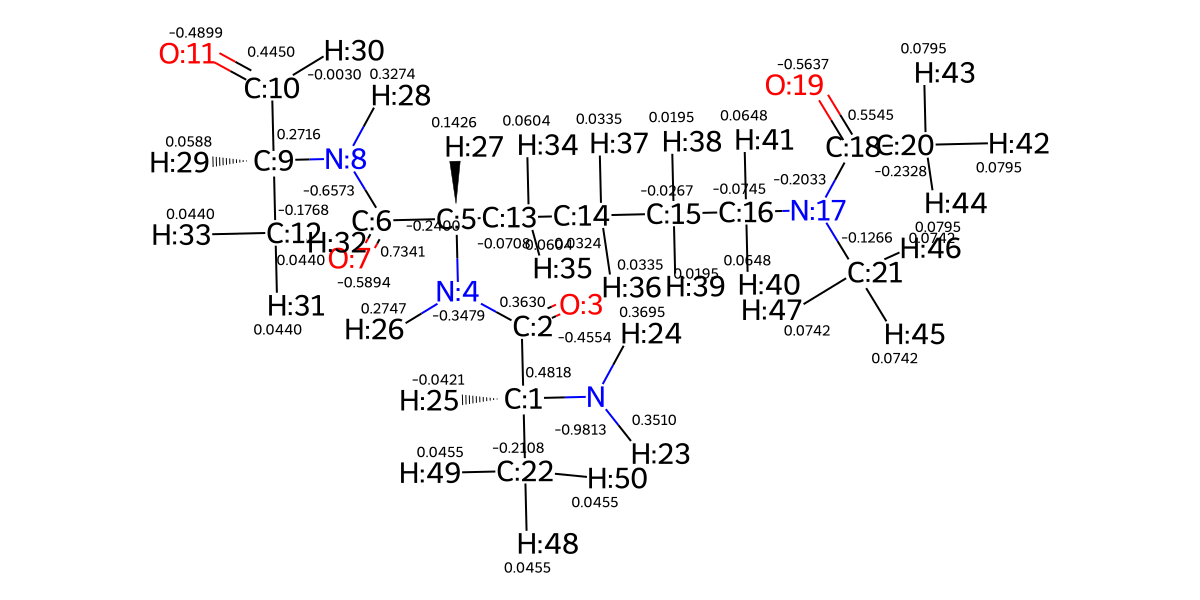

In [85]:
pt.draw_mol_with_atom_index(trimers_chem[param_mol_name], charge_list = job.molecules[0].charges, size=(1200,600))

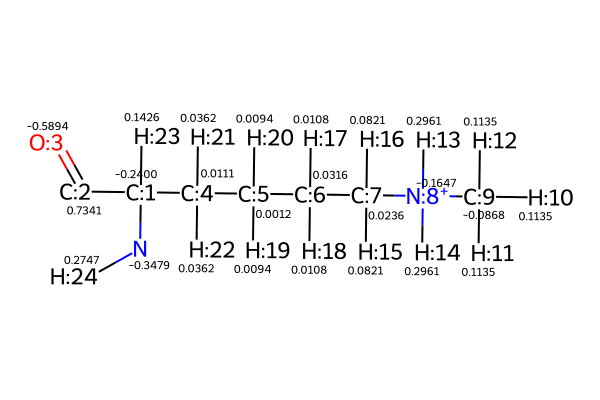

In [112]:
pt.draw_mol_with_atom_index(match_dict['substructure'][param_mol_name], charge_list = monomer_charge_list)

1.0000
[-0.3479 -0.24    0.7341 -0.5894  0.0111  0.0012  0.0316  0.0236 -0.1645
 -0.0868  0.1135  0.1135  0.1135  0.2961  0.2961  0.0821  0.0821  0.0108
  0.0108  0.0094  0.0094  0.0362  0.0362  0.1426  0.2747]


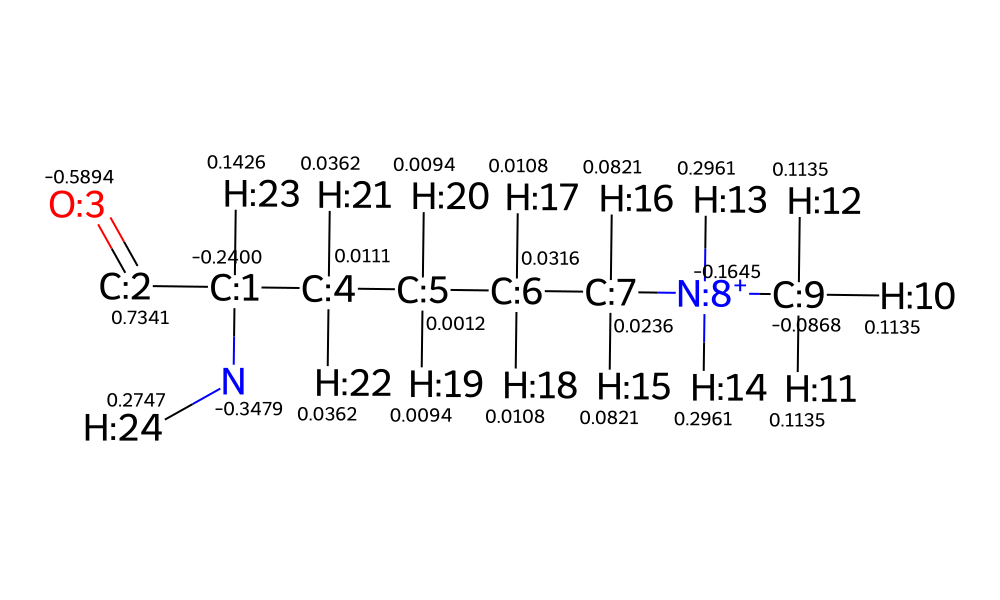

In [120]:
print(pt.calculate_true_sum(monomer_charge_list), monomer_charge_list ,sep='\n')

pt.draw_mol_with_atom_index(match_dict['substructure']['AKA_1M'], charge_list=monomer_charge_list, size=(1000,600))

In [119]:
monomer_charge_list[8] = -0.1645

In [24]:
psiresp.molecule.validator()

ConfigError: validator with no fields specified

In [22]:
job.molecules[0].charges

array([-1.0104290401482305,  0.5027465828528195,  0.3872214847902046,
       -0.4641616488583168, -0.3479            , -0.24              ,
        0.7341            , -0.5894            , -0.5916396582066681,
        0.1967896718159135,  0.3670509689189309, -0.4354372427261837,
       -0.1264235089668979, -0.0569432712708758, -0.0059703916728487,
       -0.0801676717044089,  0.0542955889918814,  0.0621391236060464,
       -0.0730034596450818, -0.0889126477770978, -0.1297016504937443,
       -0.0808878627108491,  0.3795325586050463,  0.3743537175928892,
       -0.0432257670729063,  0.2747            ,  0.1426            ,
        0.2730833260139904,  0.0711993733206094,  0.0123038101125046,
        0.0530123721800832,  0.0530123721800832,  0.0530123721800832,
        0.072980726238173 ,  0.072980726238173 ,  0.0319927848544991,
        0.0319927848544991,  0.0310626407214574,  0.0310626407214574,
        0.0697580872138257,  0.0697580872138257,  0.0994179738069756,
        0.0994179738

## Сохранение масcива зарядов

In [121]:
import json
with open('Charge_list/K_1M.json', 'w') as convert_file:
     convert_file.write(json.dumps(list(monomer_charge_list)))

In [16]:
# param_mol_name = "CR_CIT"

In [15]:
# !pwd

/home/_shared/_projects/2022_md_FRET_nv/param_R_CIT


In [ ]:
print(param_mol_name)

In [22]:
np.save(f'Charge_list/{param_mol_name}_done.npy', monomer_charge_list)


GR_CIT


In [17]:
np.load(f'Charge_list/{param_mol_name}_done.npy')

array([-1.2866,  1.0232, -0.5923, -0.5637, -0.0571,  0.045 , -0.3981,
       -0.3068,  0.8557, -0.8266, -0.8266, -0.3479,  0.2764,  0.1447,
        0.1569,  0.1569,  0.0835,  0.0835,  0.0693,  0.0693,  0.2609,
        0.4902,  0.4902])

In [145]:
with open ('Charge_list/K_3M.json') as json_file:
    chrges = json.load(json_file)

In [147]:
chrges[23] = 0.0671


In [180]:
chrges[7] = -0.2640

In [174]:
for i in [9,13,17]:
    chrges[i] = -0.1413

In [181]:
pt.calculate_true_sum(chrges)

Decimal('1.0000')

In [184]:
chrges

[-0.3479,
 -0.24,
 0.7341,
 -0.5894,
 0.059,
 -0.1197,
 0.007,
 -0.264,
 0.164,
 -0.1413,
 0.1159,
 0.1159,
 0.1159,
 -0.1413,
 0.1159,
 0.1159,
 0.1159,
 -0.1413,
 0.1159,
 0.1159,
 0.1159,
 0.1386,
 0.1386,
 0.0671,
 0.0671,
 0.0528,
 0.0528,
 0.0217,
 0.0217,
 0.1426,
 0.2747]

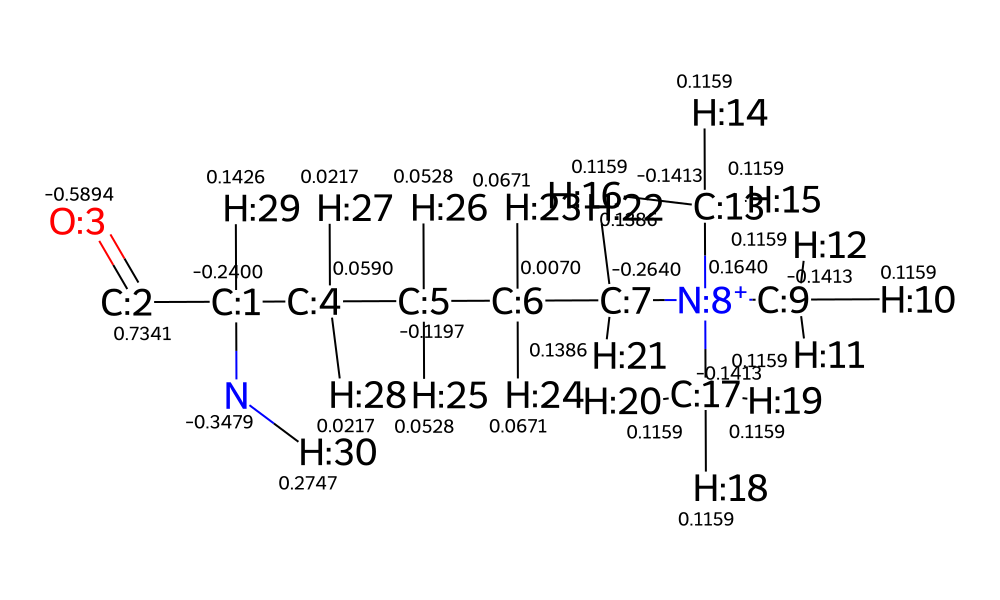

In [185]:
pt.draw_mol_with_atom_index(match_dict['substructure']['AKA'], charge_list=chrges, size=(1000,600))

In [183]:
with open('Charge_list/K_3M_mod.json', 'w') as convert_file:
     convert_file.write(json.dumps(list(chrges)))

In [15]:
type(sub_chem)

rdkit.Chem.rdchem.Mol

In [14]:
sub_chem = match_dict['substructure']['GRG_CIT']

In [16]:
mol_file_path = 'moleculse/substructure/R_CIT.mol'

In [ ]:
def save_chem_to_smiles(rdkit_mol, path):
    path_dir = path.rsplit('/', 1)
    if len(path_dir) > 1:
        os.makedirs(path_dir[0], exist_ok=True) 
    smiles_string = Chem.MolToSmiles(rdkit_mol)
    with open(f"{path}.smiles", "w") as file:
        file.write(smiles_string)

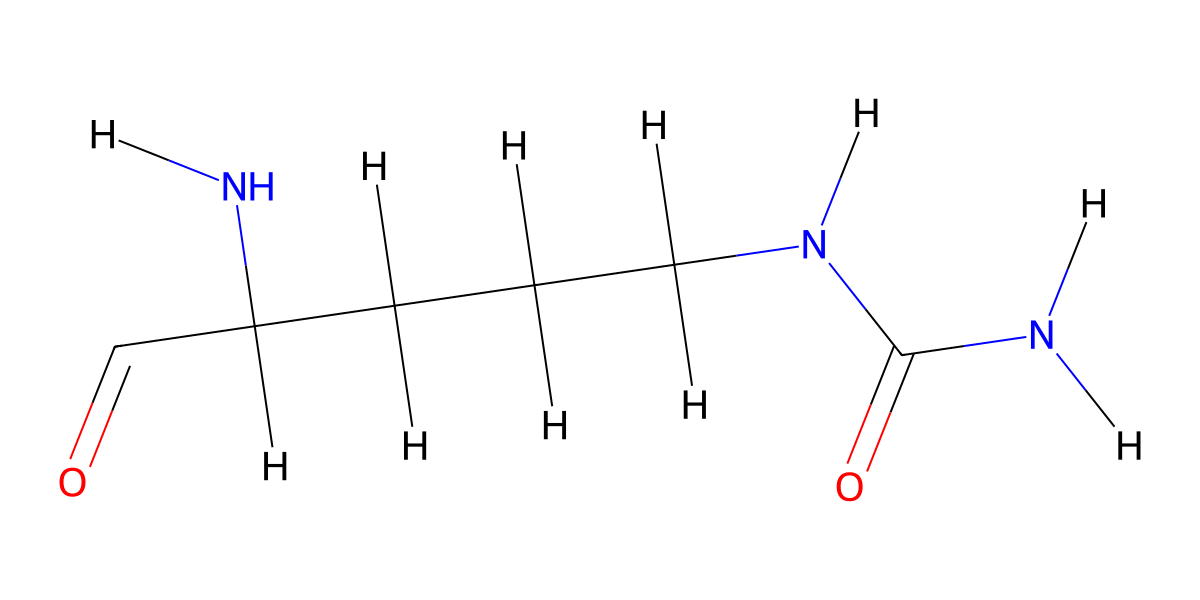

In [18]:
Chem.MolFromMolFile('moleculse/substructure/R_CIT.mol', removeHs=False)

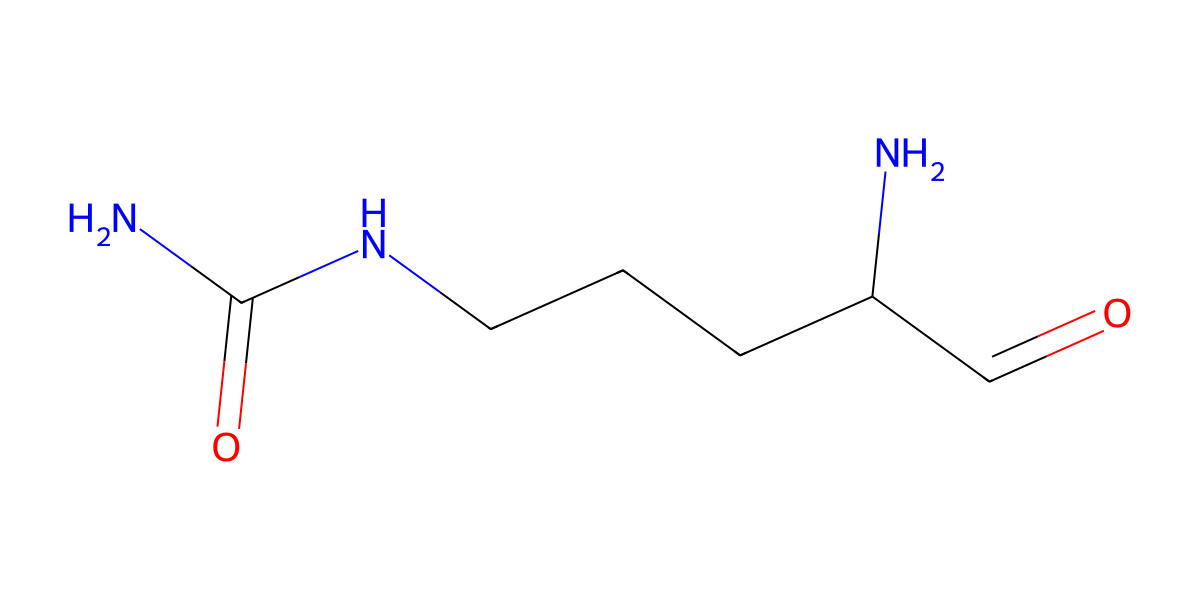

In [10]:
r_cit_smi = pt.read_file('moleculse/substructure/R_CIT.smiles')
Chem.MolFromSmiles(r_cit_smi['R_CIT'])
# dict_chem = pt.smi_to_chem(r_cit_smi )
# dict_chem['R_CIT']

In [11]:
r_cit_smi

{'R_CIT': '[N]([C](=[O])[N]([C]([C]([C]([C]([CH]=[O])([NH][H])[H])([H])[H])([H])[H])([H])[H])[H])([H])[H]'}

In [55]:
# import json
# with open('Charge_list/RA_CIT_done.json', 'w') as convert_file:
#      convert_file.write(json.dumps(monomer_charge_list))

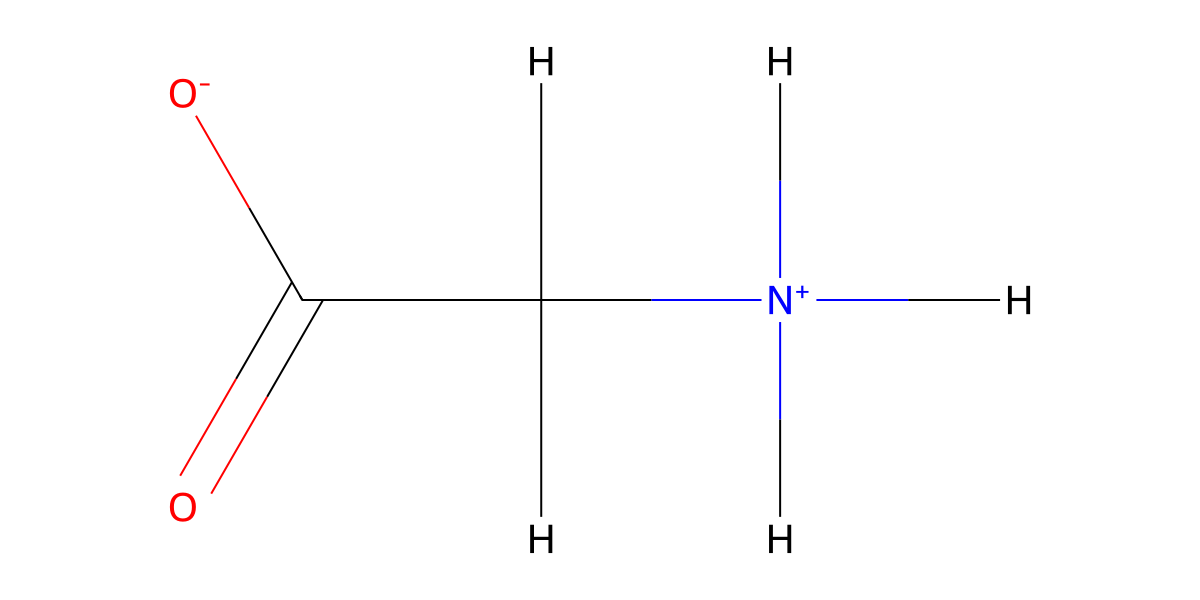

In [83]:
base = pt.read_file('AA_base.smiles')
base = Chem.MolFromSmiles(base['AA_base'], )
base = Chem.AddHs(base)
base

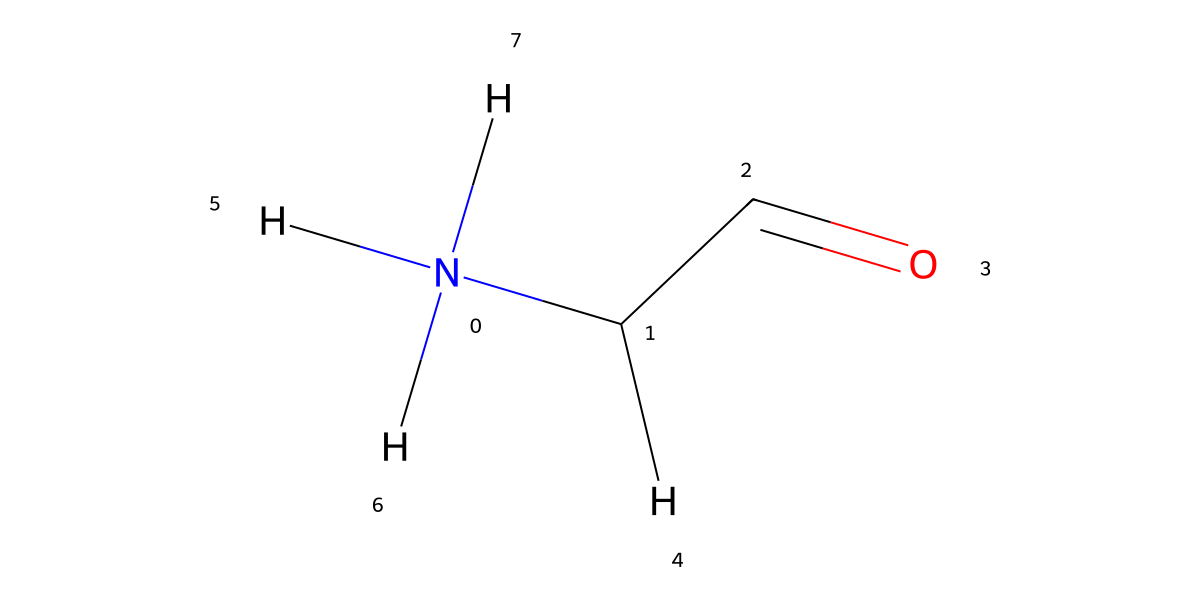

In [90]:
res = rdFMCS.FindMCS((sub_chem, base))
mcs_smarts = res.smartsString
substructure = Chem.MolFromSmarts(res.smartsString)
IPythonConsole.drawOptions.addAtomIndices = True
substructure

In [94]:
# backbone = sub_chem.GetSubstructMatches(substructure)
backbone = base.GetSubstructMatches(substructure)
backbone

((0, 1, 2, 4, 8, 5, 6, 7), (0, 1, 2, 4, 9, 5, 6, 7))

In [89]:
for atoms in backbone:
    a = m.GetAtomWithIdx(atoms[2])
    info = Chem.AtomPDBResidueInfo()
    info.SetName(" CA ") #spaces are important
    a.SetMonomerInfo(info)

((10, 7, 8, 9, 14, 11, 12, 13),)

In [83]:
def round_and_adjust(array, target_sum, precision=4):
    # Округление чисел массива до задданного порядка precision
    rounded_array = np.round(array, precision)
    
    # Находим разницу между целевой суммой и суммой округленных значений
    initial_sum = np.sum(rounded_array)
    diff = target_sum - initial_sum
    
    # Ищем уникальные значения с точностью более чем 4 знака после запятой
    unique_values, counts = np.unique(array, return_counts=True)
    eligible_indices = []
    for i, val in enumerate(array):
        # Проверка количества знаков после запятой
        decimal_part = str(val).split('.')[1]
        if len(decimal_part) > precision:
            # Проверка, что значение уникально
            index_in_unique = np.where(unique_values == val)[0][0]
            if counts[index_in_unique] == 1:
                eligible_indices.append(i)
                
    # Распределяем ошибку только между подходящими элементами
    if eligible_indices:
        correction_per_value = diff / len(eligible_indices)
        print(correction_per_value)
        for i in eligible_indices:
            rounded_array[i] += correction_per_value
    else:
        print('Не удалось выбрать заряды между которыми расперделелить сумму ошибки')
    
    # Финальная корректировка, если требуется
    final_sum = np.sum(rounded_array)
    if final_sum != target_sum:
        adjustment = target_sum - final_sum
        rounded_array[eligible_indices[-1]] += adjustment

    return rounded_array

In [84]:
monomer_charge_list
target_sum = 1.0000
adjusted_values = round_and_adjust(monomer_charge_list, target_sum, precision=4)
print(adjusted_values)
print(sum(adjusted_values))

-2.4999999999997247e-05
[-1.164725            0.9509749999999999 -0.624025
 -0.5551250000000001  0.040575            0.027475
 -0.652725           -0.0223              0.7214
 -0.6013              0.1305              0.2083
  0.2083              0.2083              0.1242
  0.2668              0.2668              0.0626
  0.0626              0.0587              0.0587
  0.2815750000000005  0.4712              0.4712            ]
1.0000000000000002


In [61]:
dec_round_list = []
for i in dec_list:
    dec_round_list.append(i.quantize(Decimal('1.0000'), ROUND_FLOOR))
sum(np.array(dec_round_list))

Decimal('0.9991')

In [16]:
charge_array = np.array(monomer_charge_list)
sum(charge_array.round(4))

1.0001999999999998

In [22]:
charge_array = charge_array.astype('float128') # longdouble
sum(charge_array.round(4).astype('float64')),

(1.0001999999999998,)

In [118]:
monomer_chem

{'R_CIT': <rdkit.Chem.rdchem.Mol at 0x7fe58297bee0>}

In [40]:
job

Job(molecules=[Molecule(name=C8H16N4O4, charge=0) with 2 conformers], qm_optimization_options=QMGeometryOptimizationOptions(method='hf', basis='6-31g*', pcm_options=None, driver='gradient', query_interval=20, protocols={'wavefunction': 'orbitals_and_eigenvalues'}, keywords={}, g_convergence='gau_tight', max_iter=200, full_hess_every=10, jobname='optimization'), qm_esp_options=QMEnergyOptions(method='hf', basis='6-31g*', pcm_options=None, driver='energy', query_interval=20, protocols={'wavefunction': 'orbitals_and_eigenvalues'}, keywords={}, jobname='single_point'), grid_options=GridOptions(grid_rmin=0, grid_rmax=-1, use_radii='msk', vdw_radii={}, vdw_scale_factors=[1.4, 1.6, 1.8, 2.0], vdw_point_density=1.0), resp_options=RespOptions(restraint_slope=0.1, restrained_fit=True, exclude_hydrogens=True, convergence_tolerance=1e-06, max_iter=500, restraint_height_stage_1=0.0005, restraint_height_stage_2=0.001, stage_2=True), charge_constraints=ChargeConstraintOptions(charge_sum_constraints=[

### Просмотр сгенерированных коформеров 

In [51]:
def show_conformer( conformer_index):
    return job.molecules[0].conformers[conformer_index].qcmol
n = len(job.molecules[0].conformers) -1
view = interact(show_conformer, conformer_index=(0,n,1) )


interactive(children=(IntSlider(value=0, description='conformer_index', max=1), Output()), _dom_classes=('widg…

In [47]:
len(job.molecules[0].conformers) - 1

1

In [10]:
job.molecules[0].conformers[1].qcmol

NGLWidget()

In [8]:
xyz_array = job.molecules[0].conformer_generation_options.generate_coordinates(job.molecules[0].conformers[0].qcmol)

In [7]:
name_of_system = 'R_CIT'
pt.run_psiresp_safely(RESP_list, name_of_system)
pt.show_list_of_conf(f'{name_of_system}/optimization/', True)

Новое имя директории: R_CIT


generate-conformers: 100%|██████████| 3/3 [18:13<00:00, 364.59s/it]

SystemExit: Exiting to allow running QM computations; commands are in R_CIT/optimization/run_optimization.sh
Колличество конформеров: 10
C10H19N5O5_c19a4abd2549d770a6476b7a4e6ba8d6622c5980_3295dc7332cc740b0c698580ccc3dd1759e5b5fe.msgpack
C10H19N5O5_4c54f2e0ab33b183f1367553e34b7d21fe9476ca_3295dc7332cc740b0c698580ccc3dd1759e5b5fe.msgpack
C10H19N5O5_cd05f07f8e3f62c2a410b3081c2859d95a172c4e_3295dc7332cc740b0c698580ccc3dd1759e5b5fe.msgpack
C10H19N5O5_f9fc58e3bf7c4e8bce95c48dad2d0c95e250429c_3295dc7332cc740b0c698580ccc3dd1759e5b5fe.msgpack
C10H19N5O5_7e56d83d65dc5cb9796e94ee01d4b0dccfa84ca8_3295dc7332cc740b0c698580ccc3dd1759e5b5fe.msgpack
C10H19N5O5_d7e7a9c69457cca6ef94b9e06237b364fe9d00d8_3295dc7332cc740b0c698580ccc3dd1759e5b5fe.msgpack
C10H19N5O5_b0f7179eadd043fa4b60939e3b479d24188028d4_3295dc7332cc740b0c698580ccc3dd1759e5b5fe.msgpack
C10H19N5O5_667c46b5a2bdfa9a29e24776b7ed7ba9e63870ea_3295dc7332cc740b0c698580ccc3dd1759e5b5fe.msgpack
C10H19N5O5_b0f8c3c682e4c266cbfb42820184ef23346ec83b_329

In [9]:
xyz_array

array([[[ 4.638295975432047 ,  3.9979149150440594,  0.132963883106045 ],
        [ 4.163683867722276 ,  3.3523828797917905, -1.0443398079096096],
        [ 4.869886430087356 ,  3.35018956261719  , -2.078783072412024 ],
        ...,
        [-4.406220898291307 , -2.76868857640632  ,  3.415886587017536 ],
        [-3.0038195328187918, -2.0315050244527577,  4.30820821334429  ],
        [-4.84306283978855  , -4.047685853986545 ,  6.867594713579183 ]],

       [[-4.916565418996202 , -3.989208249721407 , -0.8019791212129611],
        [-3.661863325225191 , -3.3384817293860003, -0.7686167405117216],
        [-3.616634163710693 , -2.1428364105300406, -1.1900242665846927],
        ...,
        [ 3.695517014124607 ,  4.044229674033296 , -2.8910427960060767],
        [ 4.647555614431996 ,  2.5450768017348   , -3.1042664311763617],
        [ 2.6442627558296214,  3.0417673491440365, -6.25472332962794  ]],

       [[ 2.3868967062122266,  5.65331350792234  , -2.45560150710838  ],
        [ 1.771323184

In [5]:
import numpy as np
import param_tool as pt

/home/n_kristovsky/.conda/envs/topmol2/lib/python3.8/site-packages/psiresp/charge.py:282: FutureWarning: `symmetric_atoms_are_equivalent` will be set to False by default for now, as it is a new feature. It will be set to True by default in the future
  warnings.warn(
/home/n_kristovsky/.conda/envs/topmol2/lib/python3.8/site-packages/psiresp/charge.py:282: FutureWarning: `symmetric_atoms_are_equivalent` will be set to False by default for now, as it is a new feature. It will be set to True by default in the future
  warnings.warn(


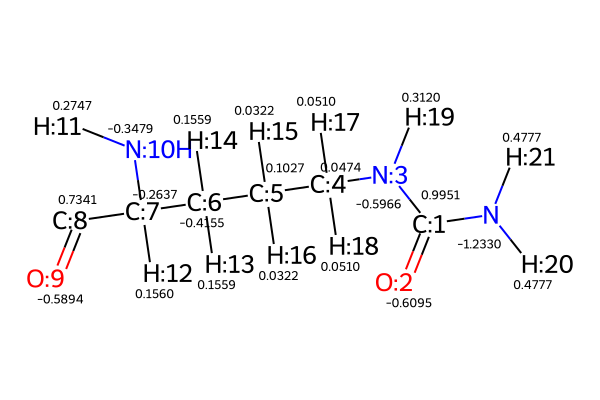

In [30]:
monomer_charge_list = np.load('Charge_list/R_CIT_done.npy')
monomer_smi = pt.read_file('moleculse/substructure/R_CIT_inter.smiles')
monomer_chem = pt.smi_to_chem(monomer_smi, addH=False,sanitize=False)
# monomer_chem = pt.pdb_to_chem('moleculse/substructure/R_CIT.pdb')
pt.draw_mol_with_atom_index(monomer_chem['R_CIT_inter'], charge_list=monomer_charge_list)

In [33]:
pt.calculate_true_sum( monomer_charge_list)

Decimal('0.0000')

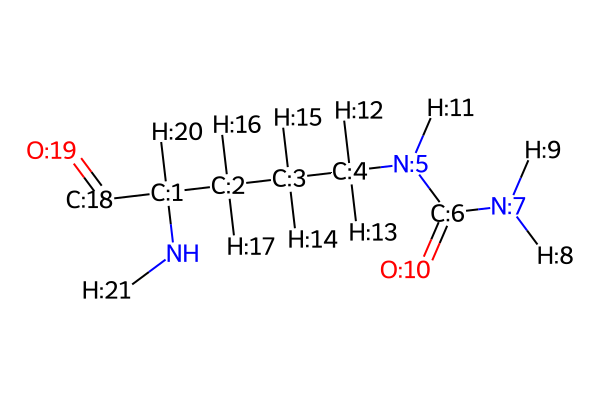

In [36]:
R_done = pt.pdb_to_chem('moleculse/mod_aa/R_CIT.pdb')
pt.draw_mol_with_atom_index(R_done['R_CIT'])

In [39]:
res_match = pt.match_chem( monomer_chem['R_CIT_inter'], R_done['R_CIT'])
res_match

(<rdkit.Chem.rdchem.Mol at 0x7f0ddec9ee20>,
 {0: 7,
  1: 6,
  2: 10,
  3: 5,
  4: 4,
  5: 3,
  6: 2,
  7: 1,
  8: 18,
  9: 19,
  10: 0,
  11: 21,
  12: 20,
  13: 16,
  14: 17,
  15: 14,
  16: 15,
  17: 12,
  18: 13,
  19: 11,
  20: 8,
  21: 9})

In [41]:
new_charge_list = [0]*22
new_charge_list

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [43]:
for old_i, new_i in res_match[1].items():
    new_charge_list[new_i] = monomer_charge_list[old_i]
new_charge_list

[-0.3479,
 -0.2637,
 -0.4155,
 0.1027,
 0.0474,
 -0.5966,
 0.9951,
 -1.233,
 0.4777,
 0.4777,
 -0.6095,
 0.312,
 0.051,
 0.051,
 0.0322,
 0.0322,
 0.1559,
 0.1559,
 0.7341,
 -0.5894,
 0.156,
 0.2747]

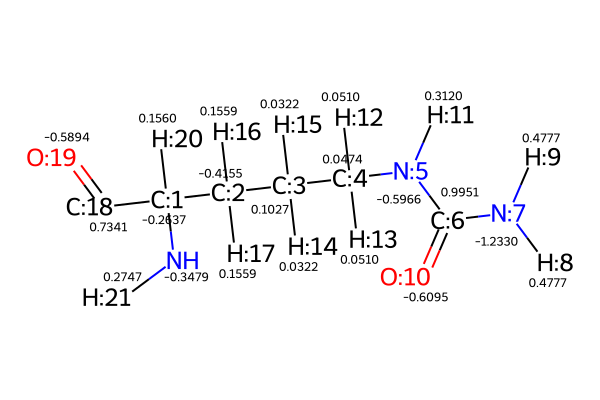

In [44]:

pt.draw_mol_with_atom_index(R_done['R_CIT'], charge_list=new_charge_list)

In [45]:
import json
with open('Charge_list/R_CIT_inter_done.json', 'w') as convert_file:
     convert_file.write(json.dumps(new_charge_list))